In [1]:
# To-do's: remove unnecessary words
# redo for mentions rather than user
# export analysis df to csv
# visualize in tableau
# Figure out how to get more than 100 tweets

In [1]:
# Library Imports
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import config
import sys
import jsonpickle
import os
from unidecode import unidecode

plt.style.use('fivethirtyeight')

In [2]:
# Set variables for API keys and tokens
ak = config.apiKey
ask = config.apiSecretKey

## Additional tokens if needed ##
    # at = config.accessToken
    # ats = config.accessTokenSecret
## --------------------------- ##

# Create authentication object
authenticate = tweepy.AppAuthHandler(ak, ask)
authenticate.secure = True

# Make the API call wait when it hits the
# rate limit then continue upon expiry of the window 
api = tweepy.API(authenticate, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Set condition for failed authentication
if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

In [3]:
# source: https://bit.ly/2WSO8El

searchQuery = 'Elon Musk'
retweet_filter = '-filter:retweets'
q = searchQuery + retweet_filter
tweetsPerQry = 100
fName = 'MuskTweets.txt'
sinceId = None

max_id = -1
maxTweets = 10000

tweetCount = 0

print(f"Downloading max {maxTweets} tweets")

with open(fName, 'w') as f:
    while tweetCount < maxTweets:
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry, lang='en')
                else:
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry, lang='en',
                                            since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry, lang='en',
                                            max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry, lang='en',
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
            if not new_tweets:
                print("No more tweets found")
                break
            for tweet in new_tweets:
                f.write(jsonpickle.encode(tweet._json['text'], unpicklable=False) + '\n')
            tweetCount += len(new_tweets)
            max_id = new_tweets[-1].id
        except tweepy.TweepError as e:
            # Just exit if any error
            print("some error : " + str(e))
            break

print (f"Downloaded {tweetCount} tweets, Saved to {fName}")

Downloaded 10093 tweets, Saved to MuskTweets.txt


In [5]:
# # Extract 100 tweets from user
# # posts = api.user_timeline(screen_name = "BillGates", count = 1000, lang = "en", tweet_mode = "extended")

# tweets = []
# # Print last 5 tweets from user
# print("5 most recent tweets: \n")

# for status in tweepy.Cursor(api.user_timeline, screen_name='@elonmusk', tweet_mode="extended").items():
#     tweets.append(status.full_text)

# i = 1

# for tweet in tweets[:5]:

#     print(str(i) + '. ' + tweet + '\n')
    
#     i += 1

In [4]:
# Create dataframe containing tweets
df = pd.read_fwf('MuskTweets.txt', sep = '\n', header = None)

df.columns = ['Tweets']

df

,Tweets
0,"""@Jorgensen4POTUS Your inability to comprehend..."
1,"""elon musk shitting on anarchist twitter like ..."
2,"""And right here is the meaning of the corporat..."
3,"""The more he talks the more I dislike Elon Mus..."
4,"""When I was a kid I got annoyed by cartoons (e..."
...,...
10088,"""elon musk has a rose emoji in his handle as t..."
10089,"""@elonmusk Elon musk cancelled once again http..."
10090,"""@elonmusk @elonmusk \nJack Dorsey - Got The I..."
10091,"""elon musk is nonbinary confirmed https://t.co..."


In [5]:
# Clean tweets
def cleanTxt(text):
    
    text = re.sub(r'@[A-Za-z0-9]+','',text) # Remove @mentions
    text = re.sub(r'#','',text) # Remove '#' symbols
    text = re.sub(r'RT[\s]+','',text) # Remove retweets
    text = re.sub(r'https?:\/\/\S+','',text) # Remove hyperlink
    text = re.sub(r':','',text) # Remove colons
    text = re.sub(r'\\u[A-Za-z0-9]+','',text) # Remove unicode
    return text

df['Tweets'] = df['Tweets'].apply(cleanTxt)

df

,Tweets
0,""" Your inability to comprehend that the big ha..."
1,"""elon musk shitting on anarchist twitter like ..."
2,"""And right here is the meaning of the corporat..."
3,"""The more he talks the more I dislike Elon Musk"
4,"""When I was a kid I got annoyed by cartoons (e..."
...,...
10088,"""elon musk has a rose emoji in his handle as t..."
10089,""" Elon musk cancelled once again"
10090,""" \nJack Dorsey - Got The Idea Of Twitter at ..."
10091,"""elon musk is nonbinary confirmed"


In [6]:
# Create a function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Create two new columns
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

df

,Tweets,Subjectivity,Polarity
0,""" Your inability to comprehend that the big ha...",0.533333,-0.500000
1,"""elon musk shitting on anarchist twitter like ...",0.333333,0.250000
2,"""And right here is the meaning of the corporat...",0.267857,0.142857
3,"""The more he talks the more I dislike Elon Musk",0.500000,0.500000
4,"""When I was a kid I got annoyed by cartoons (e...",0.800000,-0.400000
...,...,...,...
10088,"""elon musk has a rose emoji in his handle as t...",0.950000,0.600000
10089,""" Elon musk cancelled once again",0.000000,0.000000
10090,""" \nJack Dorsey - Got The Idea Of Twitter at ...",0.000000,0.000000
10091,"""elon musk is nonbinary confirmed",1.000000,0.400000


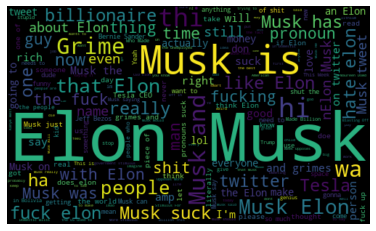

In [7]:
# Plot Word Cloud
allWords = ' '.join([twts for twts in df['Tweets']])
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()


In [12]:
# Compute negative, neutral and positive analysis

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
df['Analysis'] = df['Polarity'].apply(getAnalysis)

df.to_csv('MuskTweets.csv', encoding='utf-8', index=False)

df

,Tweets,Subjectivity,Polarity,Analysis
0,""" Your inability to comprehend that the big ha...",0.533333,-0.500000,Negative
1,"""elon musk shitting on anarchist twitter like ...",0.333333,0.250000,Positive
2,"""And right here is the meaning of the corporat...",0.267857,0.142857,Positive
3,"""The more he talks the more I dislike Elon Musk",0.500000,0.500000,Positive
4,"""When I was a kid I got annoyed by cartoons (e...",0.800000,-0.400000,Negative
...,...,...,...,...
10088,"""elon musk has a rose emoji in his handle as t...",0.950000,0.600000,Positive
10089,""" Elon musk cancelled once again",0.000000,0.000000,Neutral
10090,""" \nJack Dorsey - Got The Idea Of Twitter at ...",0.000000,0.000000,Neutral
10091,"""elon musk is nonbinary confirmed",1.000000,0.400000,Positive


In [11]:
# # Print positive tweets

# j = 1

# sortedDF = df.sort_values(by=['Polarity'], ascending=False)

# for i in range(0, sortedDF.shape[0]):
    
#     if (sortedDF['Analysis'][i] == 'Negative'):
    
#         print(str(j) + '. ' + sortedDF['Tweets'][i] + '\n')
    
#         j+=1

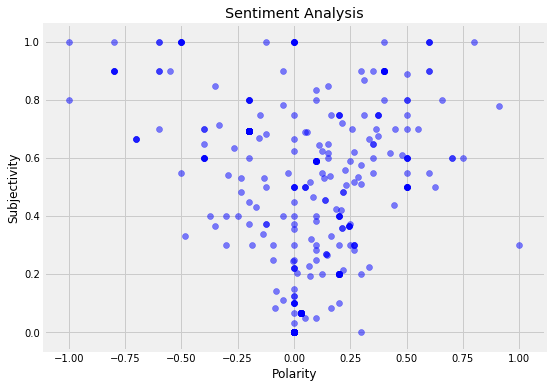

In [12]:
# Plot polarity and subjectivity

plt.figure(figsize = (8,6))

for i in range(0, df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color = 'Blue', alpha = 0.5)
    
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [9]:
# Get percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']

round((ptweets.shape[0] / df.shape[0]*100), 1)

31.2

In [10]:
# Get percentage of negative tweets
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['Tweets']

round((ntweets.shape[0] / df.shape[0]*100), 1)

28.0

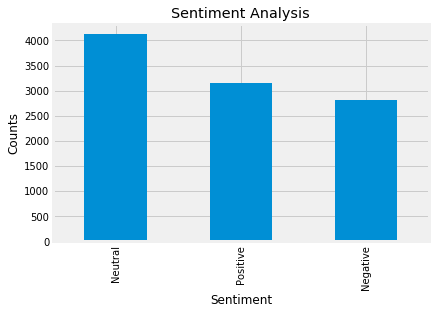

In [11]:
# Show value counts

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')

df['Analysis'].value_counts().plot(kind='bar')
plt.show()